In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from counterfactual_xai.utils.clue.bnn.gaussian_bnn import GaussianBNN
from counterfactual_xai.utils.clue.gaussian_mlp import GaussianMLP
from counterfactual_xai.utils.clue.vae.gaussian_vae import GaussianVAE
from counterfactual_xai.utils.datafeed import DataFeed
from counterfactual_xai.utils.mimic_dataloader import MimiDataLoader
from counterfactual_xai.methods.interpretation import latent_project_gauss, gen_bar_plot
from counterfactual_xai.methods.utils import LnDistance
from counterfactual_xai.methods.clue import decompose_entropy_cat, decompose_std_gauss, CLUE

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
CSV_PATH = "./../data/"
save_dir = "/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/regression/length_of_stay_regression/cleaned_dataset/state_dicts.pkl"

cuda = False
device: str = "cuda" if cuda else "cpu"
learning_rate = 1e-2

# MLP

In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd

# INPUT_DIMS = [1, 1, 8, 2]
# INPUT_DIMS = [5, 5, 41, 10]
# INPUT_DIMs bestehen aus 18 einzelnen Kategorien (hadm_id, age, max_hours, etc.) 2 one-hot Kategorien (gender_F, gender_M) und 41 one-hot Kategorien (ethnicity)
# INPUT_DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 41]

df_clean = pd.read_csv("/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/los_prediction.csv")
LOS = df_clean['LOS'].values
# Prediction Features
features = df_clean.drop(columns=['LOS'])

x_train, x_test, y_train, y_test = train_test_split(features,
                                                    LOS,
                                                    test_size=.20,
                                                    random_state=0)

y_stds = y_train.std()
y_means = y_train.mean()
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

trainset = DataFeed(x_train, y_train, transform=None)
valset = DataFeed(x_test, y_test, transform=None)

input_dim = x_train.shape[1]
width = 200
depth = 2
output_dim = 1

mlp_gauss = GaussianMLP(input_dim, width, depth, output_dim, flatten_image=False)
print(mlp_gauss.eval())

GaussianMLP(
  (block): Sequential(
    (0): Linear(in_features=49, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=2, bias=True)
  )
)


In [65]:
x_test

array([[0., 4., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 3., 0., ..., 0., 0., 0.],
       [1., 3., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

# BNN

In [4]:
N_train = x_train.shape[0]

bnn_gauss = GaussianBNN(mlp_gauss, N_train, lr=learning_rate, cuda=cuda)
bnn_gauss.load_weights(save_dir)

Total params: 0.05M


# VAE

In [5]:
INPUT_DIMS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 29]
print(sum(INPUT_DIMS))

49


In [6]:
# TODO: Train VAE on cleaned dataset
width = 300
depth = 3
latent_dim = 4

lr = 1e-4
VAE = GaussianVAE(INPUT_DIMS, width, depth, latent_dim, pred_sig=False,
                  lr=lr, cuda=cuda, flatten=False)

VAE.load(
    filename="/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/regression/length_of_stay_regression/cleaned_dataset/saves/fc_preact_VAE_d2_lsat_models_4/_models/theta_best.dat",
    device=device)


INFO:root:Loading: /Users/lukasscholz/repositorys/studienprojekt/counterfactuals/data/mimic/regression/length_of_stay_regression/cleaned_dataset/saves/fc_preact_VAE_d2_lsat_models_4/_models/theta_best.dat


    Total params: 0.40M
  restoring epoch: 437, lr: 0.000100


437

# Visualizations

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(

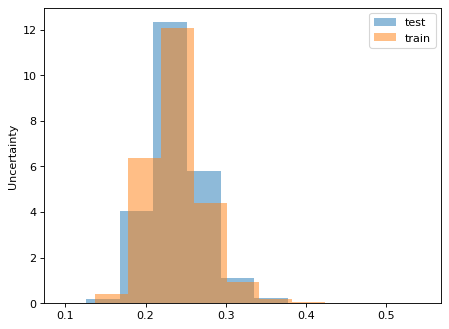

In [7]:
tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = latent_project_gauss(bnn_gauss, VAE, dset=trainset,
                                                                                     batch_size=2048, cuda=cuda)

tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec

te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = latent_project_gauss(bnn_gauss, VAE, dset=valset,
                                                                                  batch_size=2048, cuda=cuda)

te_uncertainty_vec = (te_aleatoric_vec ** 2 + te_epistemic_vec ** 2) ** (1.0 / 2)

uncertainty_idxs_sorted = np.flipud(np.argsort(te_uncertainty_vec))
aleatoric_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec))
epistemic_idxs_sorted = np.flipud(np.argsort(te_epistemic_vec))

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5)
plt.hist(tr_uncertainty_vec, density=True, alpha=0.5)
plt.legend(['test', 'train'])
plt.ylabel('Uncertainty')
plt.show()

# Uncertainty per Dimension / Feature

In [8]:
dname = "mimic"
var_names_flat = {
    "mimic": ["blood","circulatory","congenital","digestive","endocrine","genitourinary","infectious","injury","mental","misc","muscular","neoplasms","nervous","pregnancy","prenatal","respiratory","skin","GENDER","ICU","NICU","ADM_ELECTIVE","ADM_EMERGENCY","ADM_NEWBORN","ADM_URGENT","INS_Government","INS_Medicaid","INS_Medicare","INS_Private","INS_Self Pay","REL_NOT SPECIFIED","REL_RELIGIOUS","REL_UNOBTAINABLE","ETH_ASIAN","ETH_BLACK/AFRICAN AMERICAN","ETH_HISPANIC/LATINO","ETH_OTHER/UNKNOWN","ETH_WHITE","AGE_300.2","AGE_middle_adult","AGE_newborn","AGE_senior","AGE_young_adult","MAR_DIVORCED","MAR_LIFE PARTNER","MAR_MARRIED","MAR_SEPARATED","MAR_SINGLE","MAR_UNKNOWN (DEFAULT)","MAR_WIDOWED"]
}

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/lukasscholz/opt/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', va

Text(0.5, 1.0, 'epistemic')

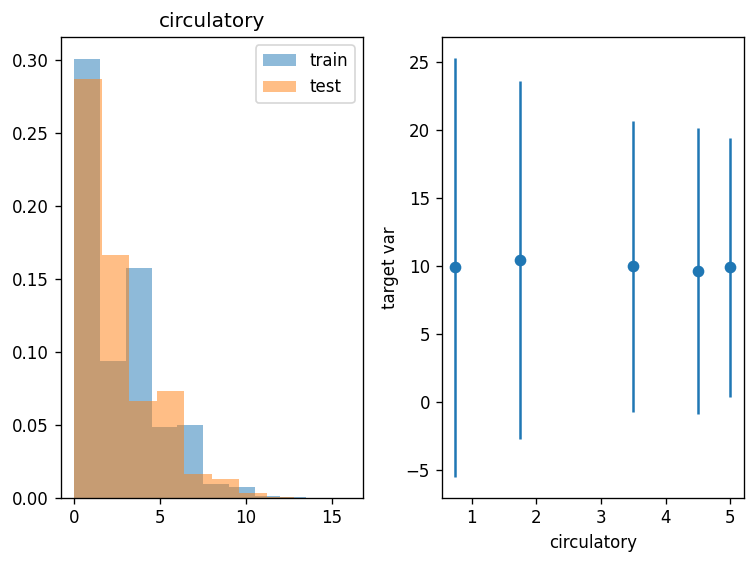

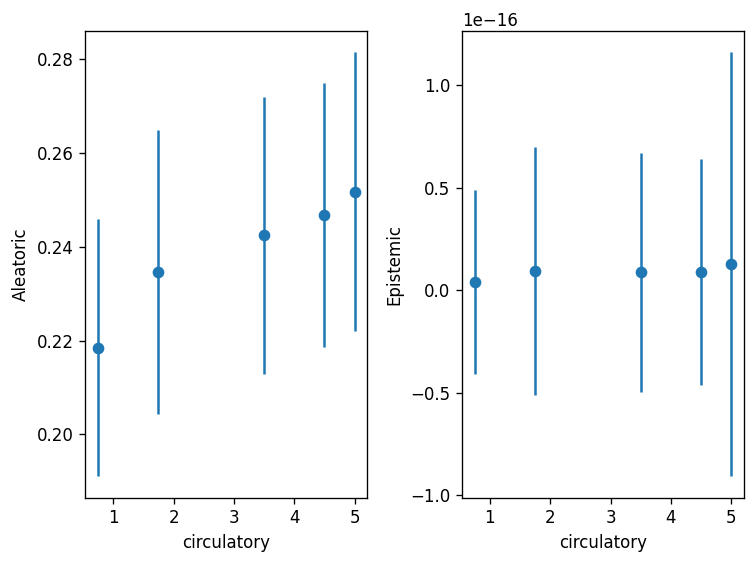

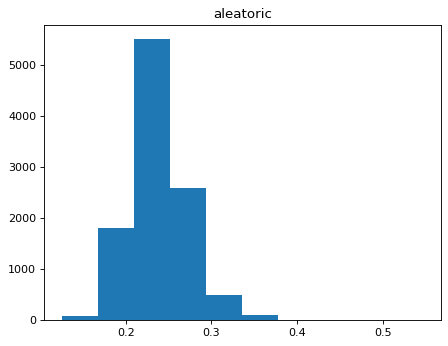

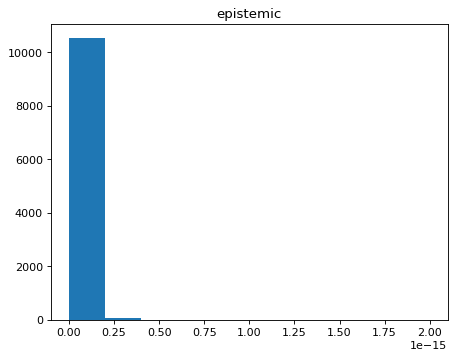

In [9]:
# var_N: Which Variable I want to analyze
var_N = 1

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].hist(x_train[:, var_N], density=True, alpha=0.5)
axes[0].hist(x_test[:, var_N], density=True, alpha=0.5)
axes[0].legend(['train', 'test'])
axes[0].set_title(var_names_flat[dname][var_N])

bins = [-5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5]
center_bins = ((np.array([0] + bins) + np.array(bins + [0])) / 2)[1:]
center_bins[-1] = bins[-1]

bin_idx = np.digitize(x_train[:, var_N], bins, right=False)
bin_means = []
bin_stds = []
aleatoric_mean = []
aleatoric_stds = []
epistemic_mean = []
epistemic_stds = []

for n_bin, bin_start in enumerate(bins):
    y_select = y_train[bin_idx == n_bin]
    aleatoric_select = tr_aleatoric_vec[bin_idx == n_bin]
    epistemic_select = tr_epistemic_vec[bin_idx == n_bin]
    if len(y_select) == 0:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)
        aleatoric_mean.append(np.nan)
        aleatoric_stds.append(np.nan)
        epistemic_mean.append(np.nan)
        epistemic_stds.append(np.nan)
    else:
        bin_means.append(y_select.mean())
        bin_stds.append(y_select.std())
        aleatoric_mean.append(aleatoric_select.mean())
        aleatoric_stds.append(aleatoric_select.std())
        epistemic_mean.append(epistemic_select.mean())
        epistemic_stds.append(epistemic_select.std())

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, bin_means, yerr=bin_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('target var')

plt.tight_layout()

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].errorbar(center_bins, aleatoric_mean, yerr=aleatoric_stds, fmt='o')
axes[0].set_xlabel(var_names_flat[dname][var_N])
axes[0].set_ylabel('Aleatoric')
# plt.show()

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, epistemic_mean, yerr=epistemic_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('Epistemic')

plt.tight_layout()
# plt.show()

plt.figure(dpi=80)
plt.hist(te_aleatoric_vec)
plt.title('aleatoric')

plt.figure(dpi=80)
plt.hist(te_epistemic_vec)
plt.title('epistemic')


# CLUE

In [10]:
use_index = uncertainty_idxs_sorted

Nbatch = 512
z_init_batch = z_test[use_index[:Nbatch]]
x_init_batch = x_test[use_index[:Nbatch]]
y_init_batch = y_test[use_index[:Nbatch]]

it 26, all conditions met, stopping
it 27, all conditions met, stopping
it 28, all conditions met, stopping
it 29, all conditions met, stopping
it 30, all conditions met, stopping
it 31, all conditions met, stopping
it 32, all conditions met, stopping
it 33, all conditions met, stopping
it 34, all conditions met, stopping
it 35, all conditions met, stopping
it 36, all conditions met, stopping
it 37, all conditions met, stopping
it 38, all conditions met, stopping
it 39, all conditions met, stopping
it 40, all conditions met, stopping
it 41, all conditions met, stopping
it 42, all conditions met, stopping
it 43, all conditions met, stopping
it 44, all conditions met, stopping
it 45, all conditions met, stopping
it 46, all conditions met, stopping
it 47, all conditions met, stopping
it 48, all conditions met, stopping
it 49, all conditions met, stopping
it 50, all conditions met, stopping
it 51, all conditions met, stopping
it 52, all conditions met, stopping
it 53, all conditions met, s

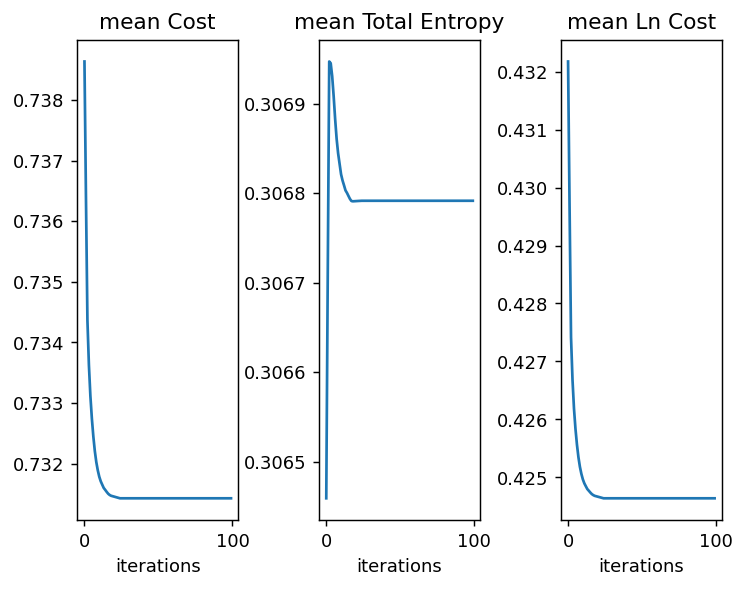

In [11]:
from counterfactual_xai.methods.clue import CLUE

torch.autograd.set_detect_anomaly(True)
torch.cuda.empty_cache()

dist = LnDistance(n=1, dim=1)
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]

aleatoric_weight = 0
epistemic_weight = 0
uncertainty_weight = 1

# Both weights are set to 1?
# distance_weight = 1.5 / x_dim
distance_weight = 1.5 / x_dim
prediction_similarity_weight = 0

mu_vec, std_vec = bnn_gauss.sample_predict(x_init_batch, 0, grad=False)
o_uncert, o_aleatoric, o_epistemic = decompose_std_gauss(mu_vec, std_vec)
desired_preds = mu_vec.mean(dim=0).cpu().numpy()

CLUE_explainer = CLUE(VAE, bnn_gauss, x_init_batch, uncertainty_weight=uncertainty_weight,
                      aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                      prior_weight=0, distance_weight=distance_weight,
                      latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                      lr=1e-2, desired_preds=None, cond_mask=None, distance_metric=dist,
                      z_init=z_init_batch, norm_MNIST=False,
                      flatten_BNN=False, regression=True, cuda=False)

torch.autograd.set_detect_anomaly(False)

# clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
    min_steps=3, max_steps=100,
    n_early_stop=3)

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)


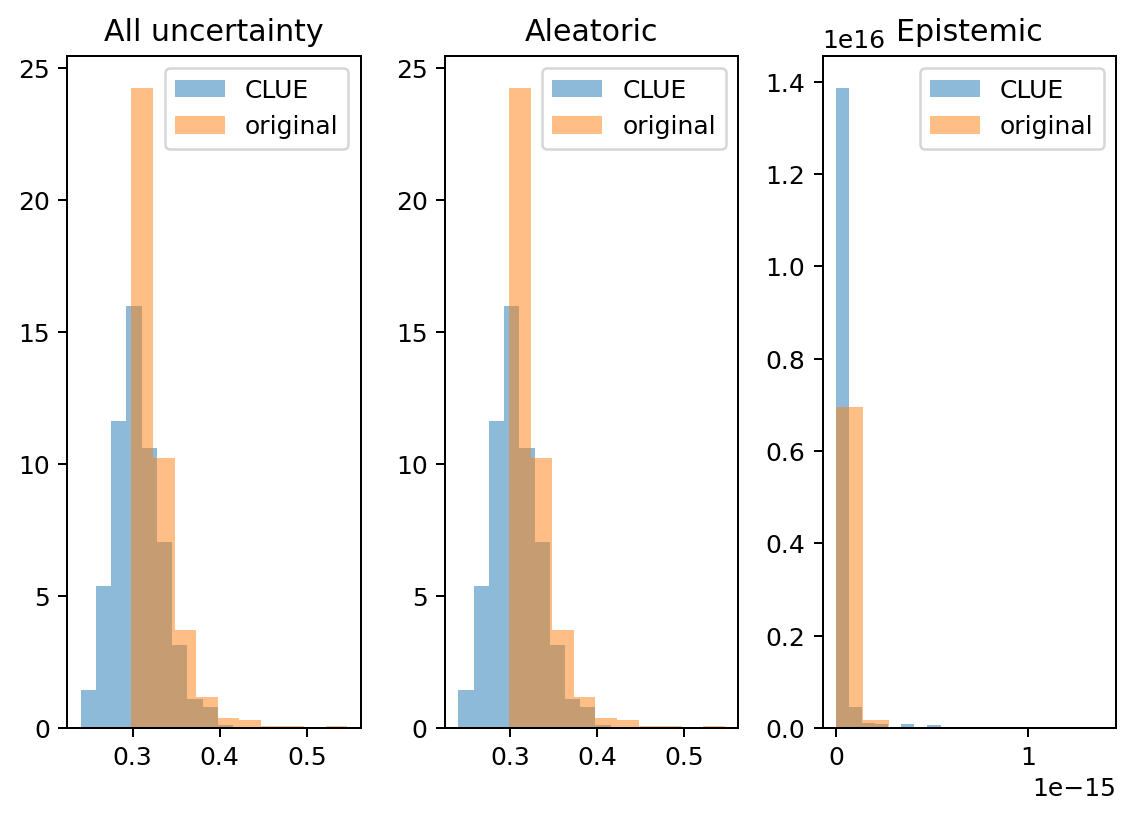

In [12]:
mu_vec, std_vec = bnn_gauss.sample_predict(x_vec[-1], num_samples=0, grad=False)
post_uncert, post_aleatoric, post_epistemic = decompose_std_gauss(mu_vec, std_vec)
post_preds = mu_vec.mean(dim=0).detach().cpu().numpy()

fig, axes = plt.subplots(1, 3, dpi=180)

axes[0].hist(post_uncert.detach().cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[0].hist(te_uncertainty_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[0].set_title('All uncertainty')
axes[0].legend()

axes[1].hist(post_aleatoric.detach().cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[1].hist(te_aleatoric_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[1].set_title('Aleatoric')
axes[1].legend()

axes[2].hist(post_epistemic.detach().cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[2].hist(te_epistemic_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[2].set_title('Epistemic')
axes[2].legend()

plt.tight_layout()


# Comparison

# Most Uncertain Prediction

In [121]:
Nsample = 10

print(f"Patient: {x_init_batch[Nsample, :]}")
print(f"Uncertainty Vector: {x_vec[-1, Nsample, :]}")

Patient: [3. 4. 0. 5. 5. 1. 1. 8. 2. 5. 0. 0. 0. 0. 0. 5. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0.]
Uncertainty Vector: [ 2.1024735   3.3347418  -0.02401757  5.435668    4.8876643   1.5022979
  2.6189919   6.7159004   1.9466127   3.3394947   0.4826998   0.60303414
  1.1305563  -0.04921478  0.4221335   4.586399    0.9610771   0.38504434
  0.97380775 -0.02403602  0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]


In [122]:
highest_value = np.argmax(post_uncert.detach().cpu().numpy())
post_uncert.detach().cpu().numpy()[highest_value]

0.41527787

/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/counterfactual_xai/methods/interpretation.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=fs)  # Set y-tick label size


o pred;  -0.14266193 pred;  -0.14846396


<Axes: title={'center': 'clue 0.24047236'}>

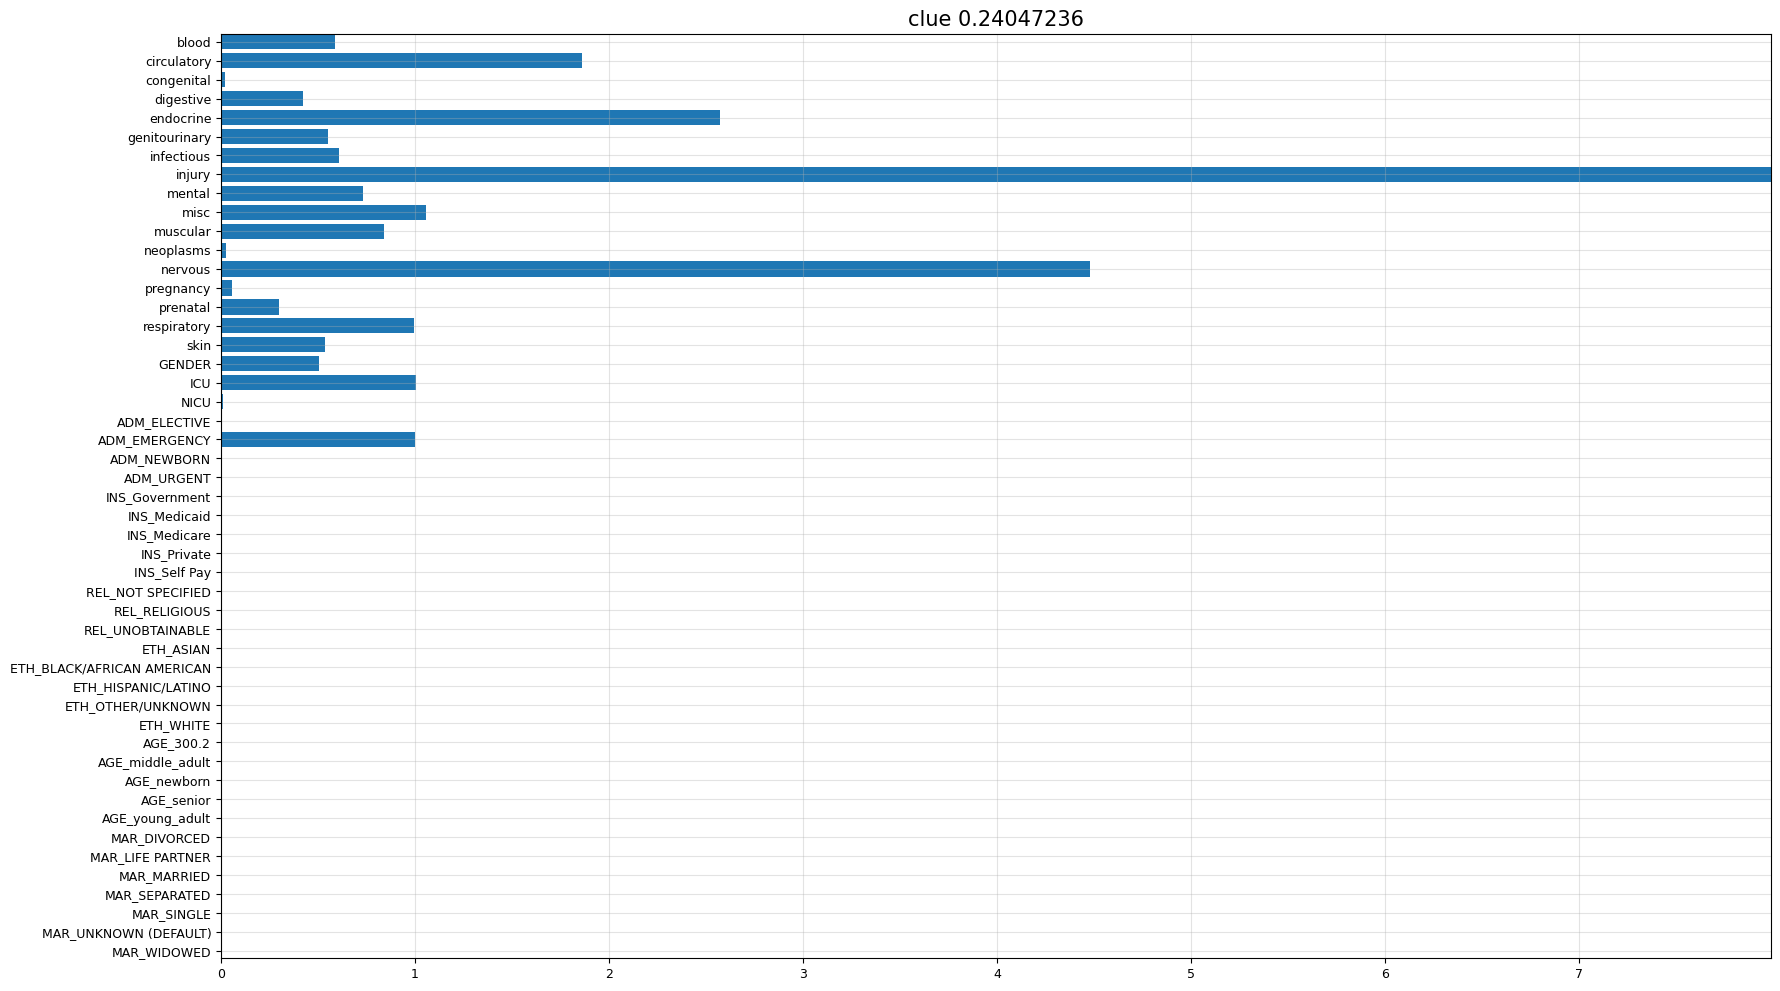

In [129]:
from counterfactual_xai.methods.interpretation import gen_bar_plot


print('o pred; ', desired_preds[Nsample, 0], 'pred; ', post_preds[Nsample, 0])

"""gen_bar_plot(var_names_flat[dname], x_init_batch[Nsample], title='og ' + str(te_uncertainty_vec[use_index[Nsample]]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=62, fs=9, verbose=False, sort=False, dpi=100, neg_color=True, ax=None, c=None)"""

"""gen_bar_plot(var_names_flat[dname], x_vec[0, Nsample, :], title='vae ' + str(uncertainty_vec[0, Nsample]), xlabel=None,
             ylabel=None, probs=False, hor=True, save_file=None, max_fields=62, fs=9, verbose=False, sort=False, dpi=100,
             neg_color=True, ax=None, c=None)"""

gen_bar_plot(var_names_flat[dname], x_vec[-1, Nsample, :],
             title='clue ' + str(post_uncert.detach().cpu().numpy()[Nsample]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=62, fs=9, verbose=False, sort=False, dpi=100, neg_color=True, ax=None, c=None)


- Uncertainty value is either positive or negative
- negative values indicate, that those features help to make the model more certain
- positive values indicate, that thoe feature make the model uncertaint
    - erasing those feature importances should lead to a more certain model

In [130]:
Nsample = np.argmin(post_uncert.detach().cpu().numpy())
print(f"Uncertainty: {post_uncert.detach().cpu().numpy()[Nsample]}")

print(f"Patient: {x_init_batch[Nsample, :]}")
print(f"Uncertainty Vector: {x_vec[-1, Nsample, :]}")

Uncertainty: 0.24047236144542694
Patient: [0. 2. 0. 1. 2. 2. 2. 8. 0. 2. 2. 0. 5. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0.]
Uncertainty Vector: [0.58596563 1.8620375  0.01984915 0.42276445 2.5708065  0.5503299
 0.60661507 7.990138   0.73213977 1.0579942  0.8399875  0.02351752
 4.479781   0.05878583 0.29827228 0.99717164 0.538791   0.50765806
 1.0035703  0.00911274 0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


/Users/lukasscholz/repositorys/studienprojekt/counterfactuals/counterfactual_xai/methods/interpretation.py:126: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels, fontsize=fs)  # Set y-tick label size


o pred;  -0.14266193 pred;  -0.14846396


<Axes: title={'center': 'clue 0.24047236'}>

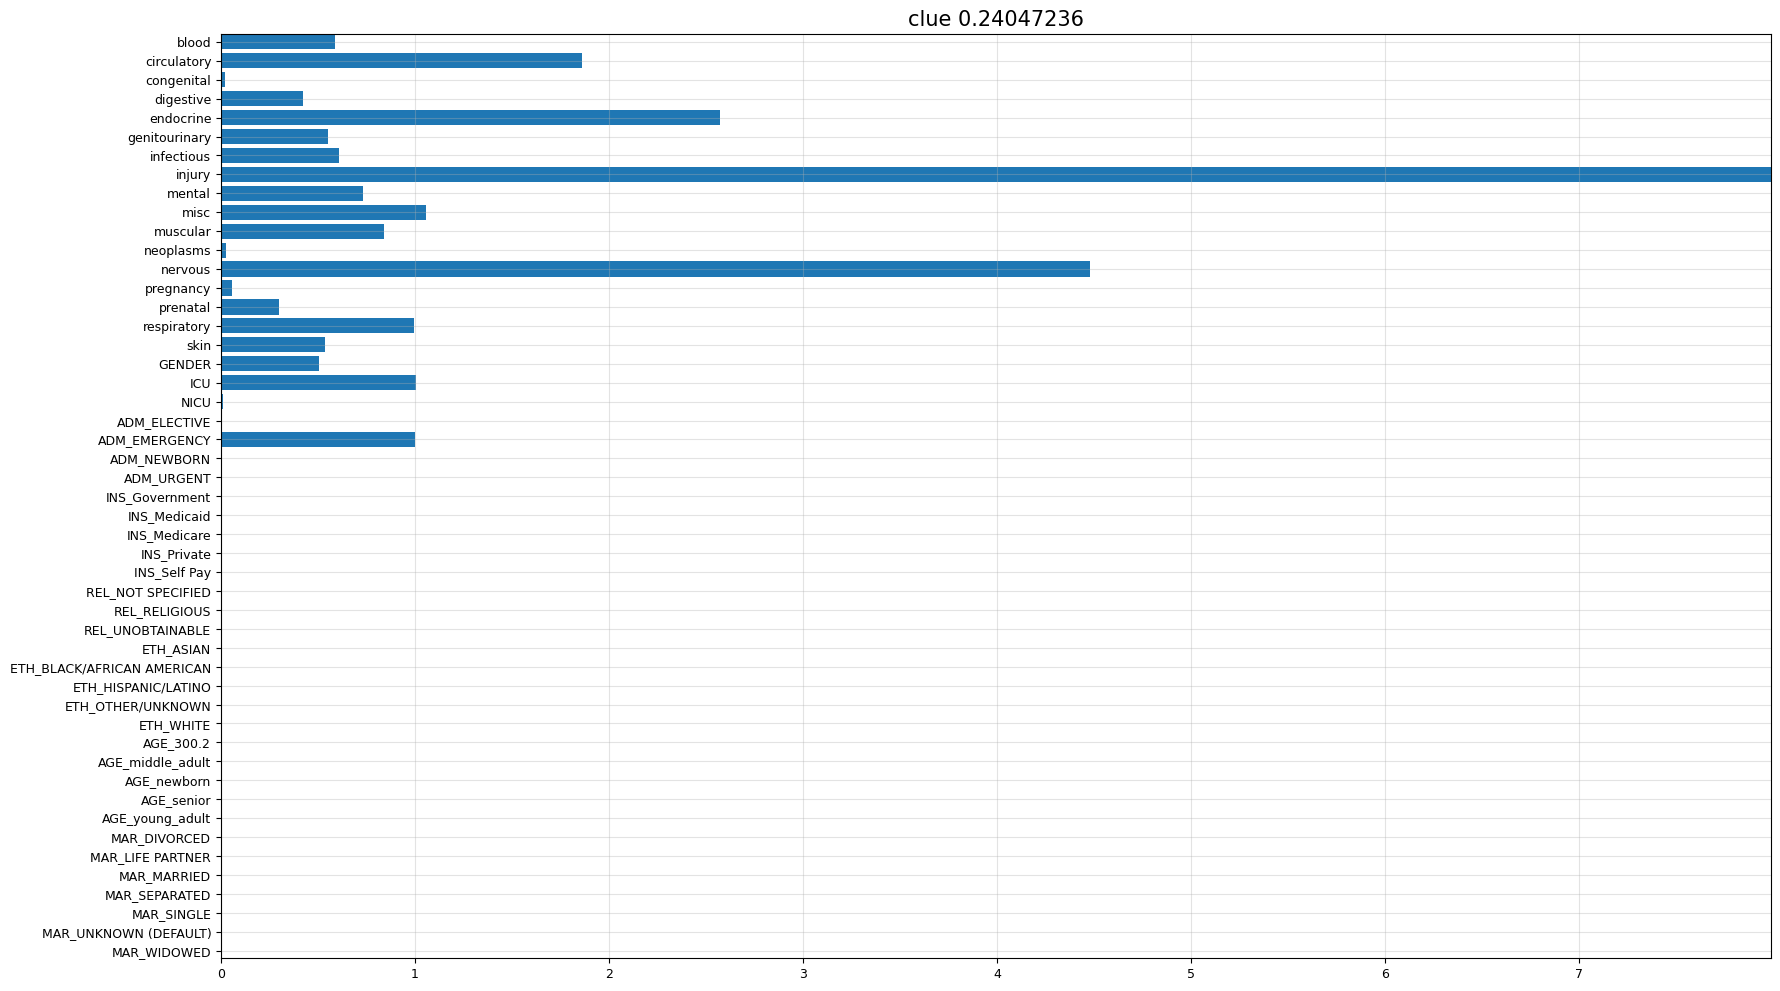

In [131]:
from counterfactual_xai.methods.interpretation import gen_bar_plot



print('o pred; ', desired_preds[Nsample, 0], 'pred; ', post_preds[Nsample, 0])

"""gen_bar_plot(var_names_flat[dname], x_init_batch[Nsample], title='og ' + str(te_uncertainty_vec[use_index[Nsample]]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=62, fs=9, verbose=False, sort=False, dpi=100, neg_color=True, ax=None, c=None)"""

"""gen_bar_plot(var_names_flat[dname], x_vec[0, Nsample, :], title='vae ' + str(uncertainty_vec[0, Nsample]), xlabel=None,
             ylabel=None, probs=False, hor=True, save_file=None, max_fields=62, fs=9, verbose=False, sort=False, dpi=100,
             neg_color=True, ax=None, c=None)"""

gen_bar_plot(var_names_flat[dname], x_vec[-1, Nsample, :],
             title='clue ' + str(post_uncert.detach().cpu().numpy()[Nsample]),
             xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
             max_fields=62, fs=9, verbose=False, sort=False, dpi=100, neg_color=True, ax=None, c=None)


In [238]:
sorted_indices = np.argsort(post_uncert.detach().cpu().numpy())

top_10_highest_indices = sorted_indices[-100:]

top_10_lowest_indices = sorted_indices[:100]


In [239]:
from dataclasses import dataclass


@dataclass
class Patient:
    blood: float
    circulatory: float
    congenital: float
    digestive: float
    endocrine: float
    genitourinary: float
    infectious: float
    injury: float
    mental: float
    misc: float
    muscular: float
    neoplasms: float
    nervous: float
    pregnancy: float
    prenatal: float
    respiratory: float
    skin: float
    GENDER: float
    ICU: float
    NICU: float
    ADM_ELECTIVE: float
    ADM_EMERGENCY: float
    ADM_NEWBORN: float
    ADM_URGENT: float
    INS_Government: float
    INS_Medicaid: float
    INS_Medicare: float
    INS_Private: float
    INS_Self_Pay: float
    REL_NOT_SPECIFIED: float
    REL_RELIGIOUS: float
    REL_UNOBTAINABLE: float
    ETH_ASIAN: float
    ETH_BLACK_AFRICAN_AMERICAN: float
    ETH_HISPANIC_LATINO: float
    ETH_OTHER_UNKNOWN: float
    ETH_WHITE: float
    AGE_300_2: float
    AGE_middle_adult: float
    AGE_newborn: float
    AGE_senior: float
    AGE_young_adult: float
    MAR_DIVORCED: float
    MAR_LIFE_PARTNER: float
    MAR_MARRIED: float
    MAR_SEPARATED: float
    MAR_SINGLE: float
    MAR_UNKNOWN_DEFAULT: float
    MAR_WIDOWED: float

In [240]:
import statistics
from dataclasses import fields, asdict


def create_patient_from_list(data):
    field_names = [f.name for f in fields(Patient)]
    
    if len(data) != len(field_names):
        raise ValueError("Length of data does not match the number of fields in Patient class")
    patient_data = dict(zip(field_names, data))
    
    return Patient(**patient_data)

def calculate_statistics(patients):
    patients_dicts = [asdict(patient) for patient in patients]
    
    stats = {field: {"mean": None, "median": None, "std": None} for field in patients_dicts[0]}
    
    for field in patients_dicts[0]:
        values = [patient[field] for patient in patients_dicts]
        
        stats[field]["mean"] = statistics.mean(values)
        stats[field]["median"] = statistics.median(values)
        stats[field]["std"] = np.std(values, ddof=1)
    
    return stats

In [241]:
patients_highest = []
for highest in top_10_highest_indices:
    patient_data = x_init_batch[highest]
    patients_highest.append(create_patient_from_list(patient_data))
    
statistics_highest = calculate_statistics(patients_highest)

# Print statistics in a nice format
for field, stat in statistics_highest.items():
    print(f"{field}:")
    print(f"  Mean: {stat['mean']}")
    print(f"  Median: {stat['median']}")
    print(f"  Standard Deviation: {stat['std']}")
    print()

blood:
  Mean: 1.159999966621399
  Median: 1.0
  Standard Deviation: 0.9289941787719727

circulatory:
  Mean: 5.440000057220459
  Median: 6.0
  Standard Deviation: 2.7203683853149414

congenital:
  Mean: 0.05000000074505806
  Median: 0.0
  Standard Deviation: 0.21904291212558746

digestive:
  Mean: 2.680000066757202
  Median: 2.0
  Standard Deviation: 2.546060562133789

endocrine:
  Mean: 4.96999979019165
  Median: 5.0
  Standard Deviation: 1.737611174583435

genitourinary:
  Mean: 2.2100000381469727
  Median: 2.0
  Standard Deviation: 1.2656694650650024

infectious:
  Mean: 1.2100000381469727
  Median: 1.0
  Standard Deviation: 1.0569156408309937

injury:
  Mean: 4.099999904632568
  Median: 4.0
  Standard Deviation: 2.435014009475708

mental:
  Mean: 0.5899999737739563
  Median: 0.0
  Standard Deviation: 0.7533762454986572

misc:
  Mean: 1.3600000143051147
  Median: 1.0
  Standard Deviation: 1.3597384691238403

muscular:
  Mean: 0.5899999737739563
  Median: 0.0
  Standard Deviation: 0

In [242]:
patients_lowest = []
for lowest in top_10_lowest_indices:
    patient_data = x_init_batch[lowest]
    patients_lowest.append(create_patient_from_list(patient_data))
    
statistics_lowest = calculate_statistics(patients_lowest)

for field, stat in statistics_lowest.items():
    print(f"{field}:")
    print(f"  Mean: {stat['mean']}")
    print(f"  Median: {stat['median']}")
    print(f"  Standard Deviation: {stat['std']}")
    print()

blood:
  Mean: 0.23000000417232513
  Median: 0.0
  Standard Deviation: 0.46828722953796387

circulatory:
  Mean: 3.3399999141693115
  Median: 3.0
  Standard Deviation: 2.4790842533111572

congenital:
  Mean: 0.1899999976158142
  Median: 0.0
  Standard Deviation: 0.6620292663574219

digestive:
  Mean: 1.3600000143051147
  Median: 1.0
  Standard Deviation: 1.4036027193069458

endocrine:
  Mean: 2.2300000190734863
  Median: 2.0
  Standard Deviation: 1.3915691375732422

genitourinary:
  Mean: 1.3300000429153442
  Median: 1.0
  Standard Deviation: 1.0641542673110962

infectious:
  Mean: 0.7599999904632568
  Median: 0.0
  Standard Deviation: 1.016231894493103

injury:
  Mean: 2.5799999237060547
  Median: 2.0
  Standard Deviation: 2.0159964561462402

mental:
  Mean: 0.4399999976158142
  Median: 0.0
  Standard Deviation: 0.715202808380127

misc:
  Mean: 0.9700000286102295
  Median: 1.0
  Standard Deviation: 0.958270788192749

muscular:
  Mean: 0.5199999809265137
  Median: 0.0
  Standard Deviat

In [243]:
patients_dicts = [asdict(patient) for patient in patients_highest]
    
stats = {field: {"mean": None, "median": None, "std": None} for field in patients_dicts[0]}

patients_data = {}
for field in patients_dicts[0]:
    columnn_name = field
    columns_value = [patient[field] for patient in patients_dicts]
    patients_data[columnn_name] = columns_value

df_highest = pd.DataFrame(data=patients_data)

In [244]:
patients_dicts = [asdict(patient) for patient in patients_lowest]
    
stats = {field: {"mean": None, "median": None, "std": None} for field in patients_dicts[0]}

patients_data = {}
for field in patients_dicts[0]:
    columnn_name = field
    columns_value = [patient[field] for patient in patients_dicts]
    patients_data[columnn_name] = columns_value

df_lowest = pd.DataFrame(data=patients_data)

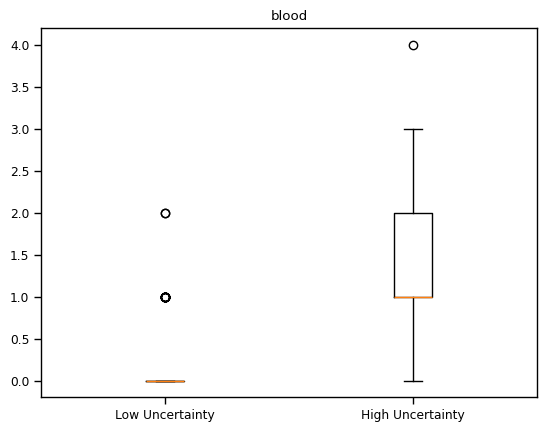

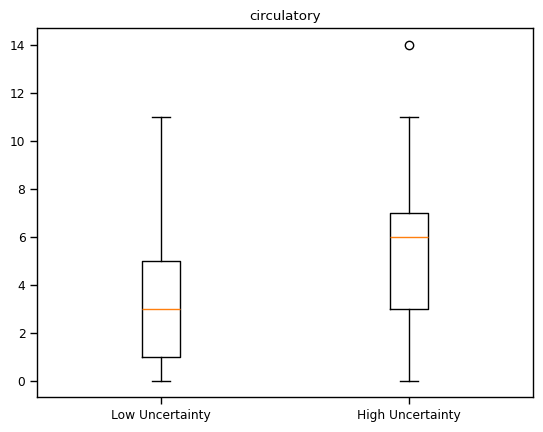

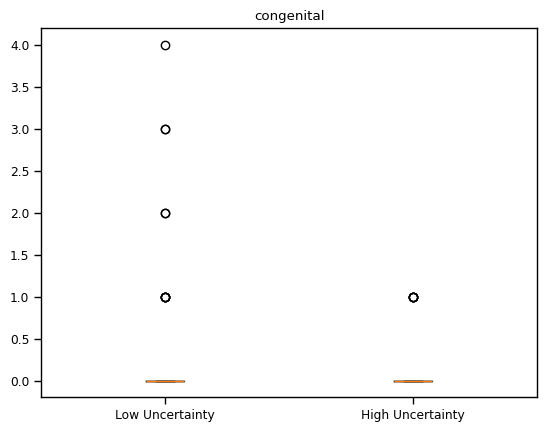

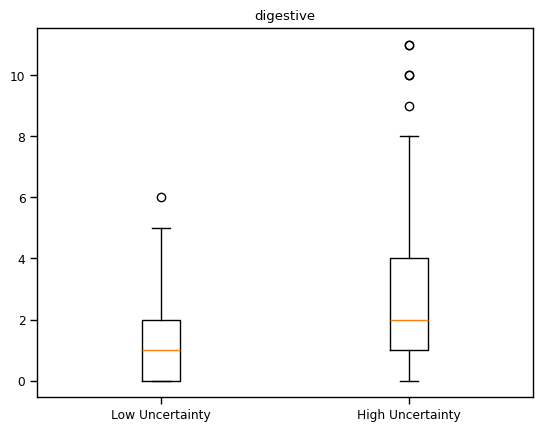

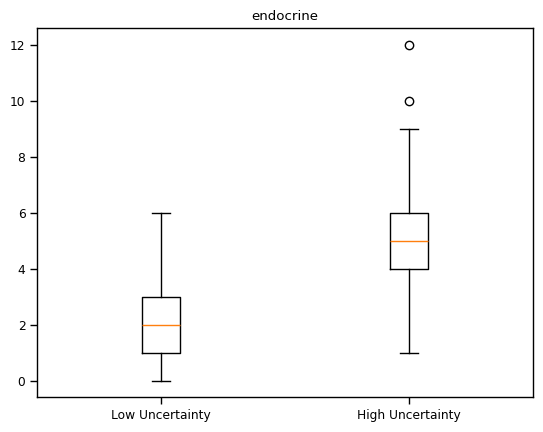

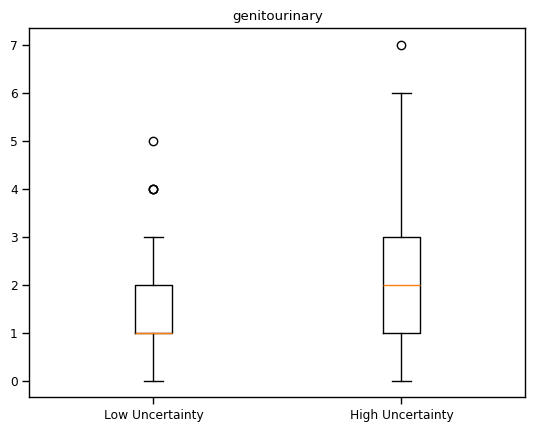

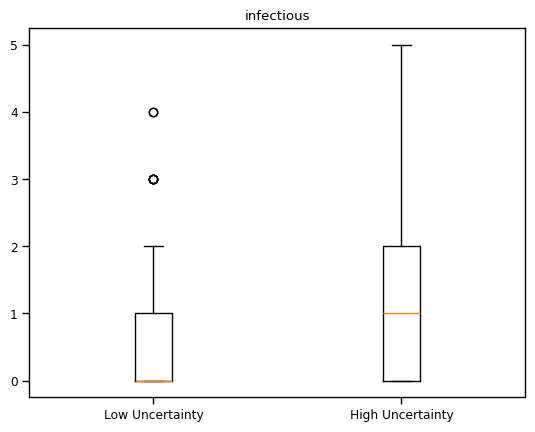

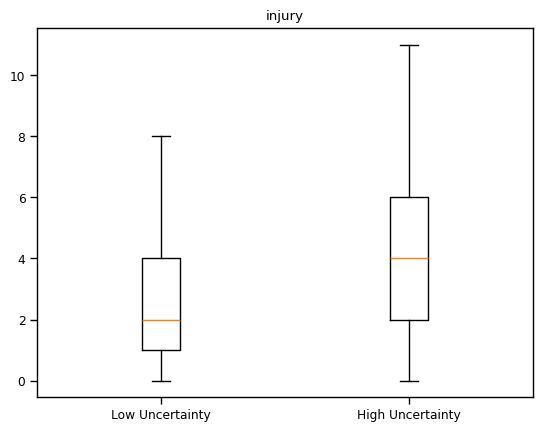

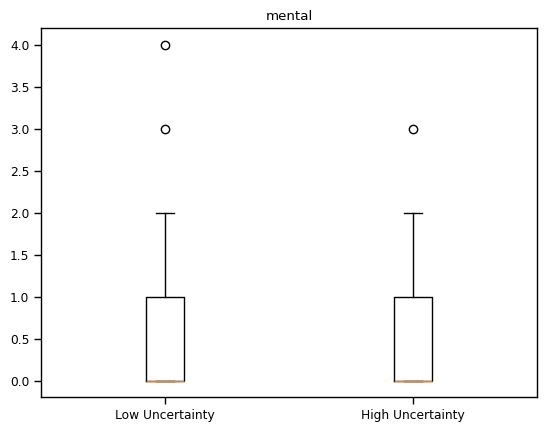

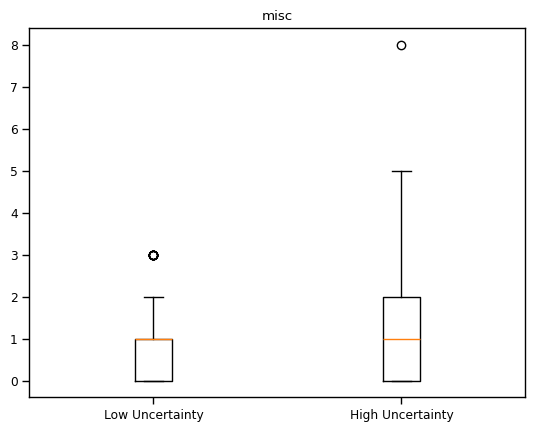

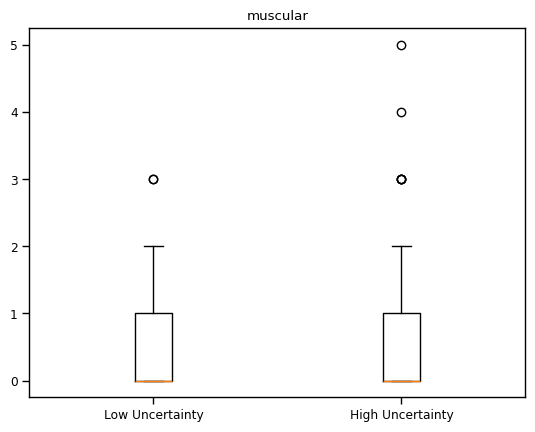

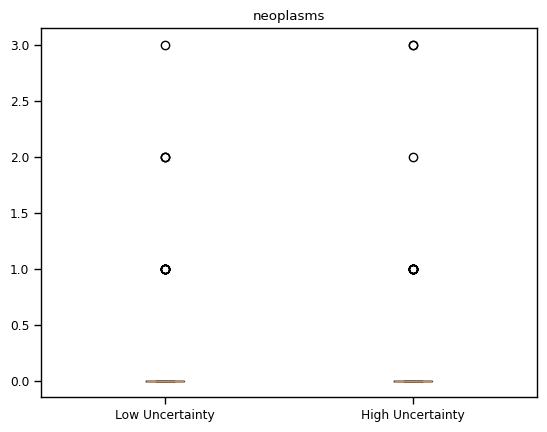

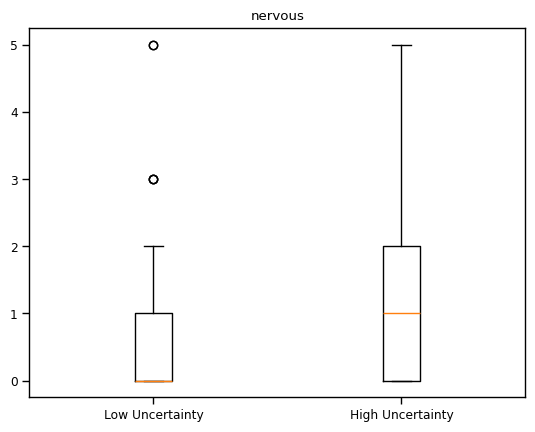

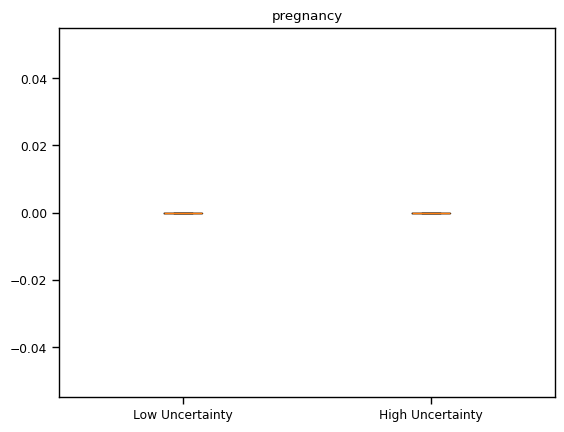

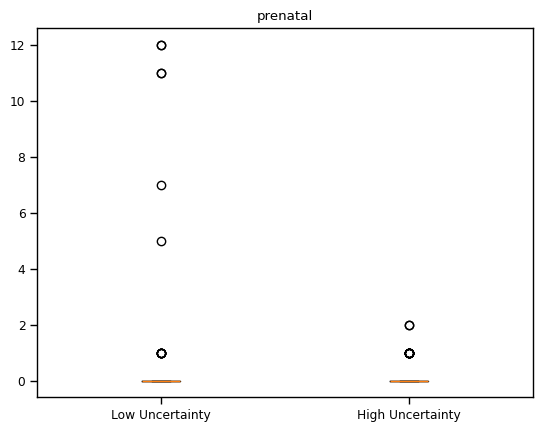

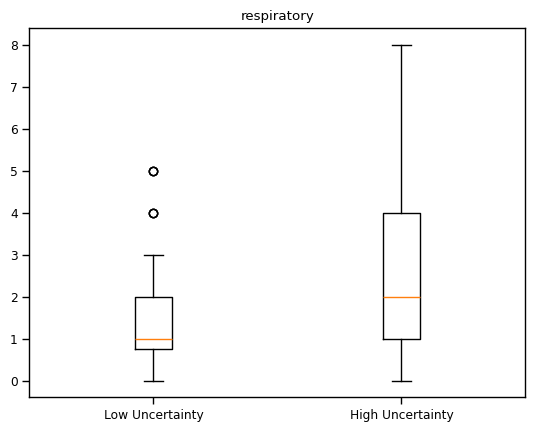

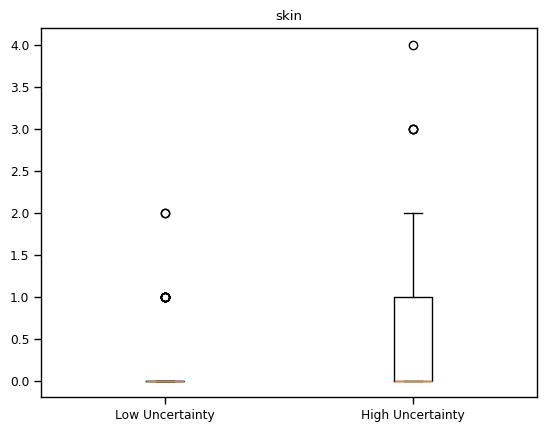

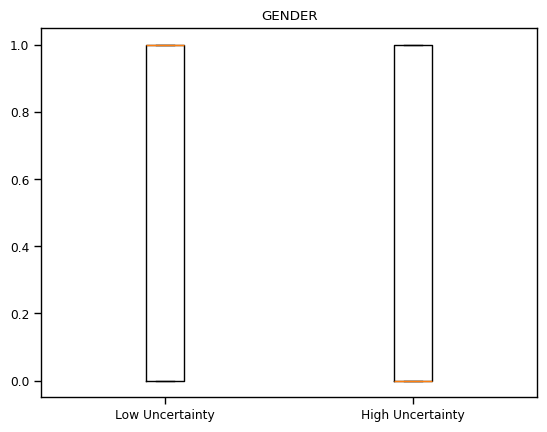

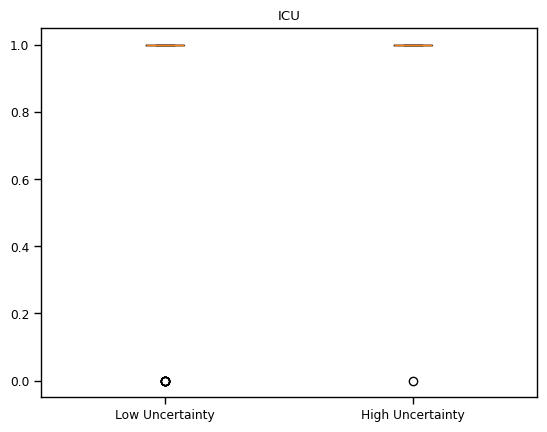

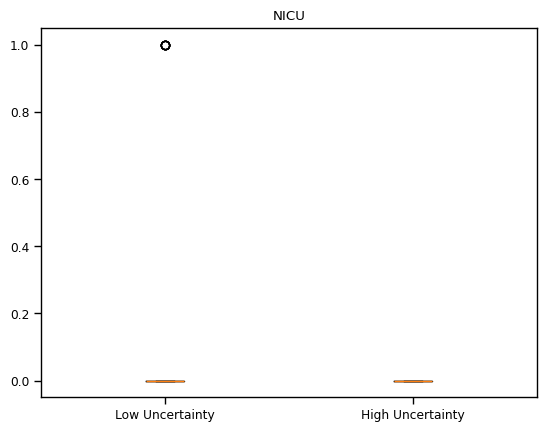

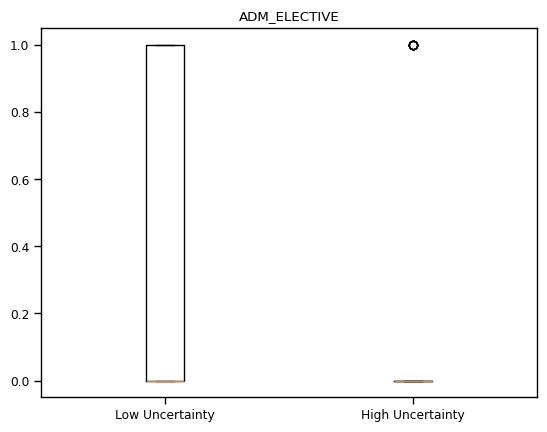

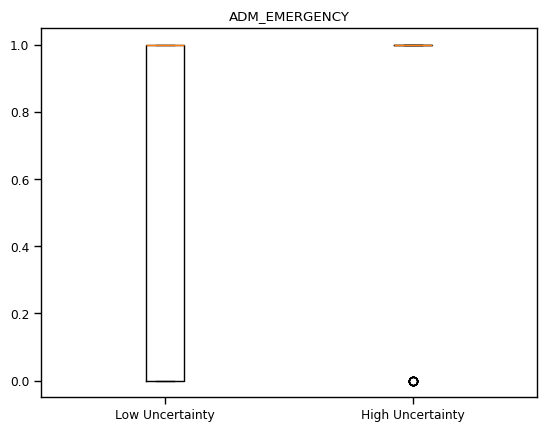

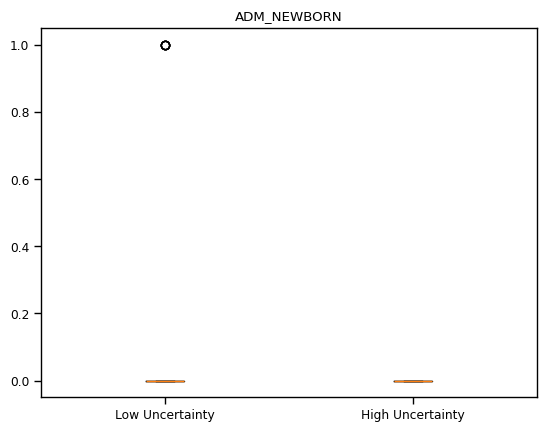

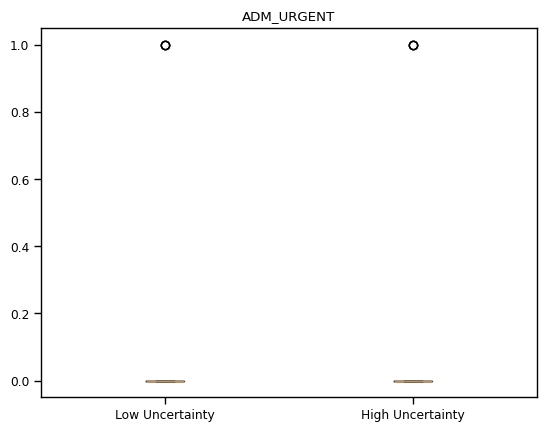

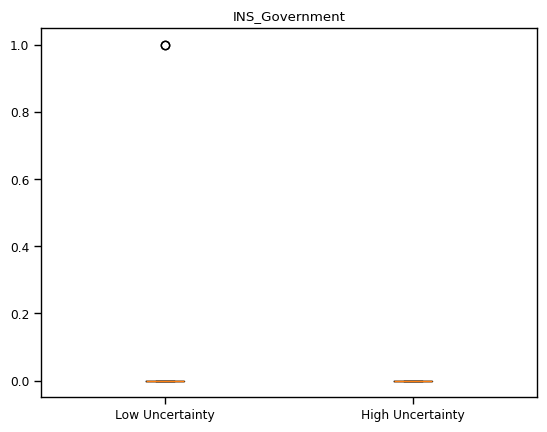

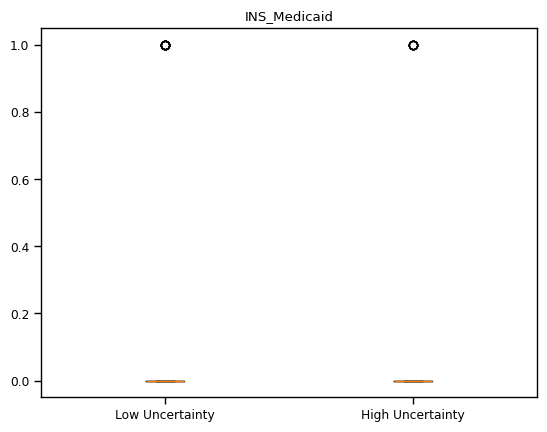

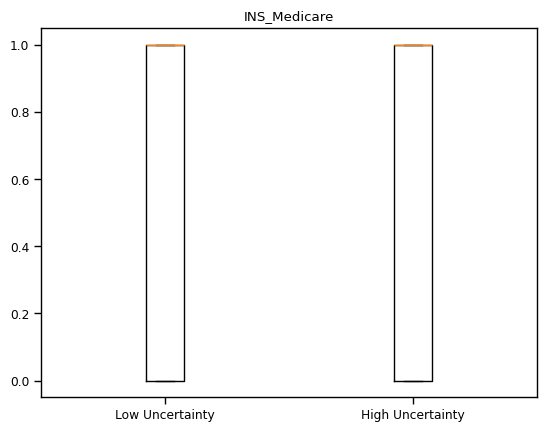

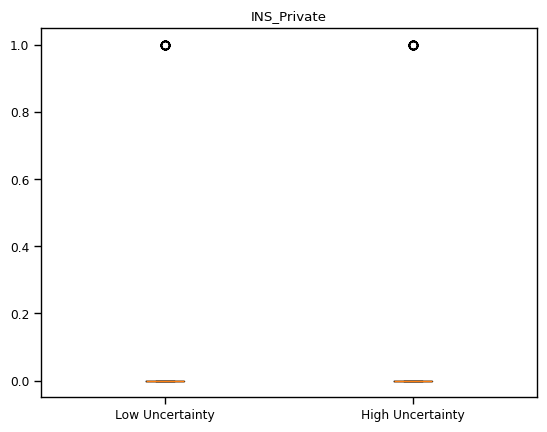

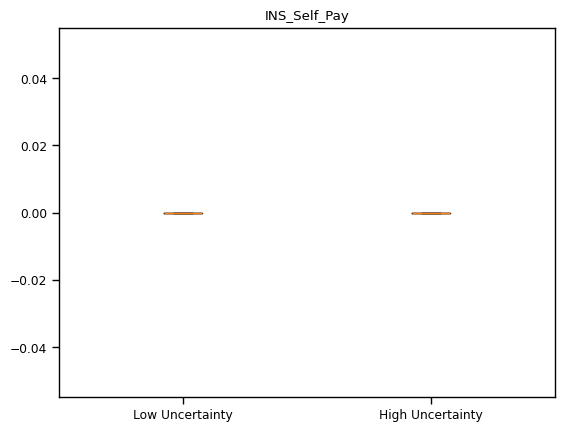

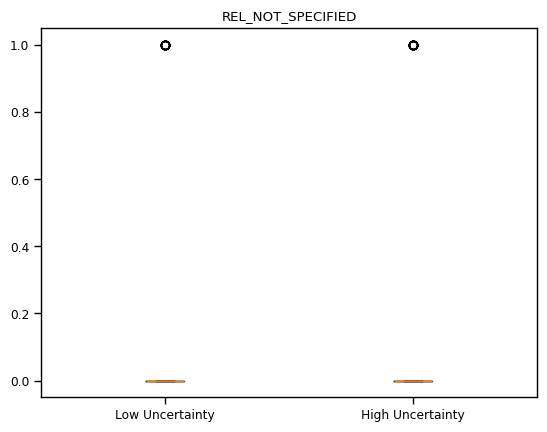

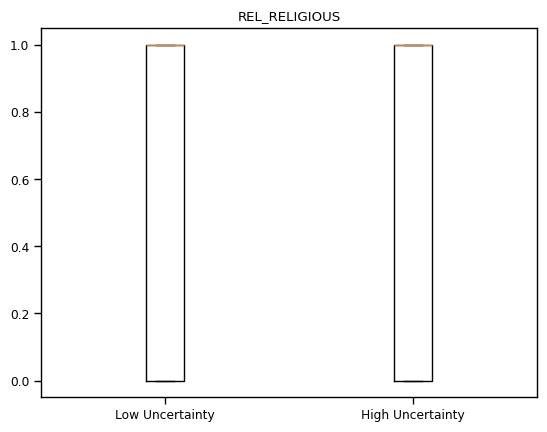

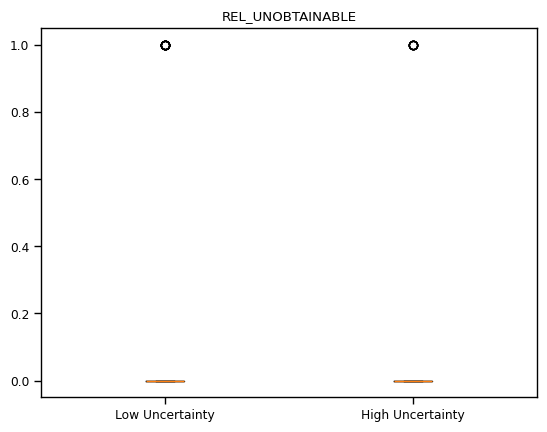

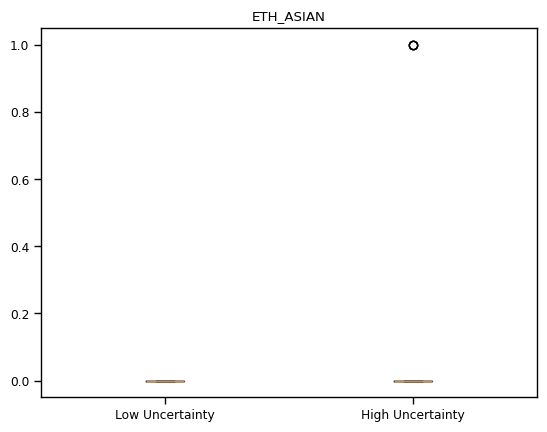

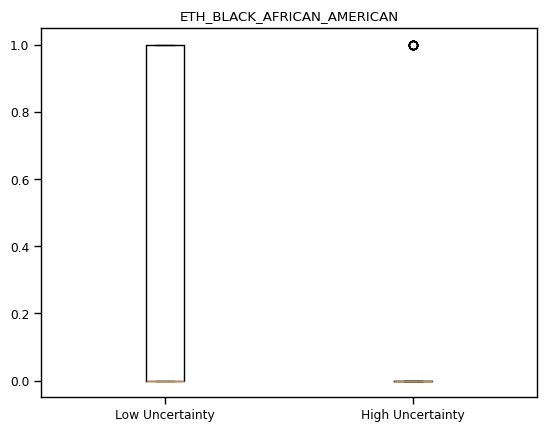

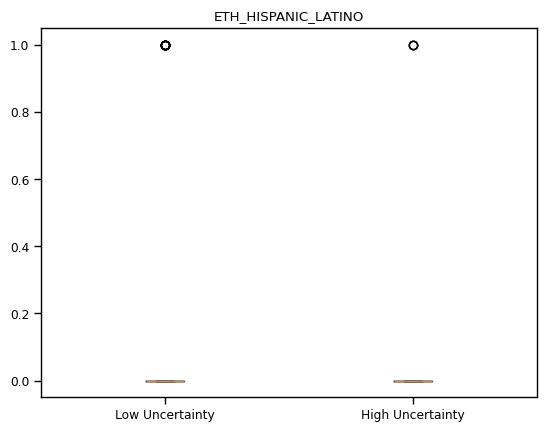

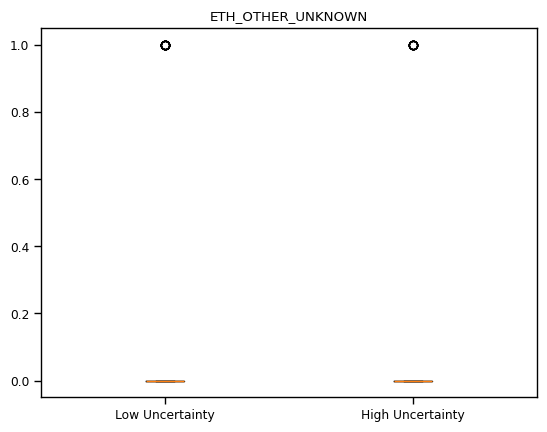

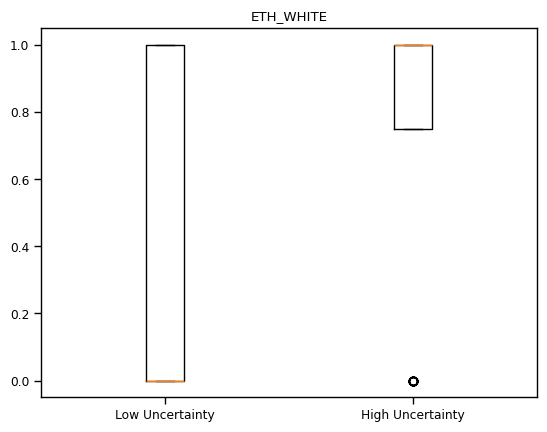

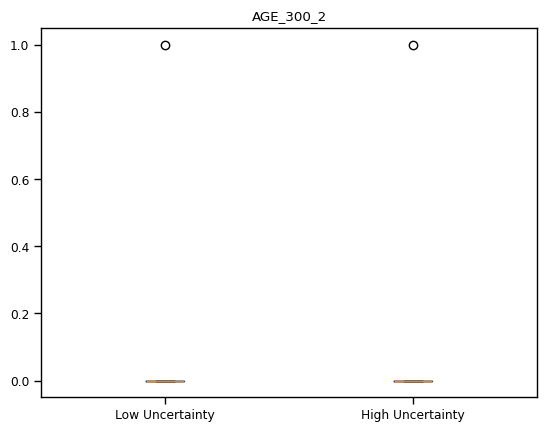

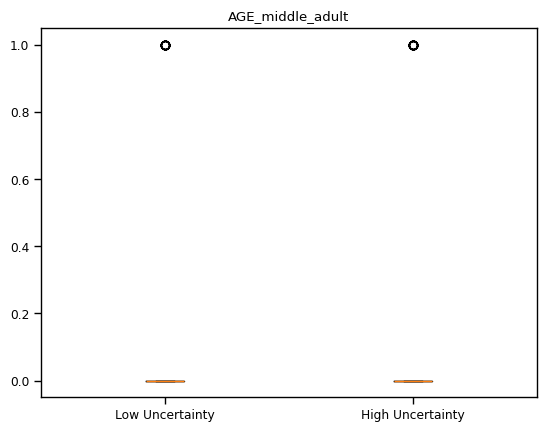

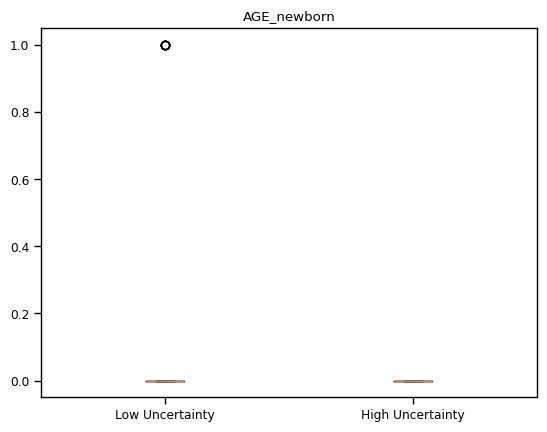

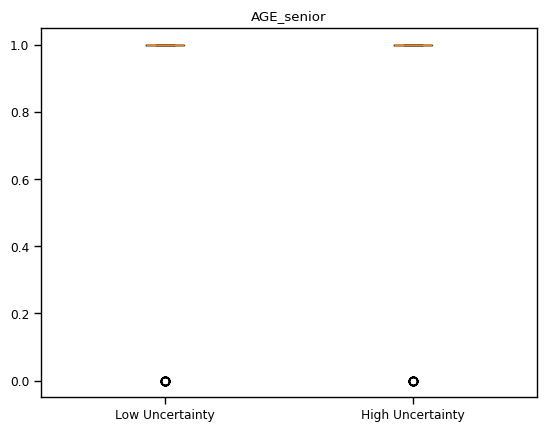

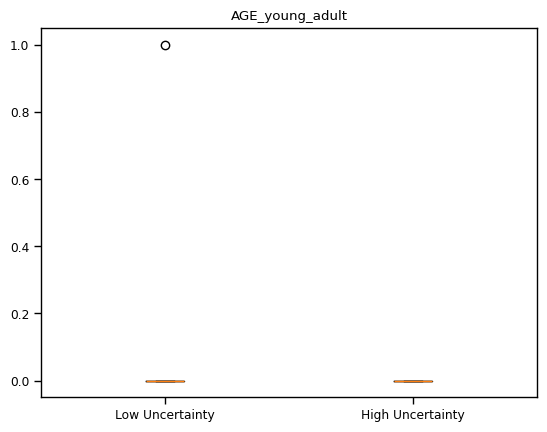

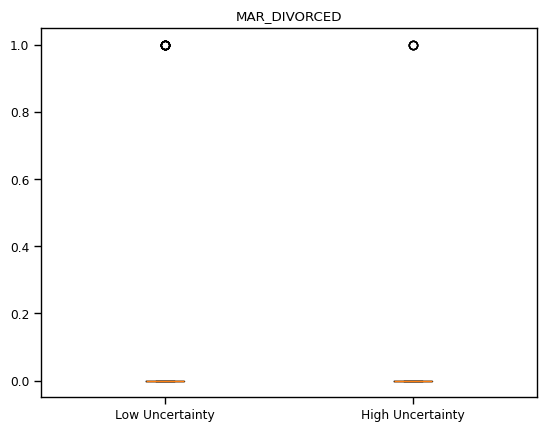

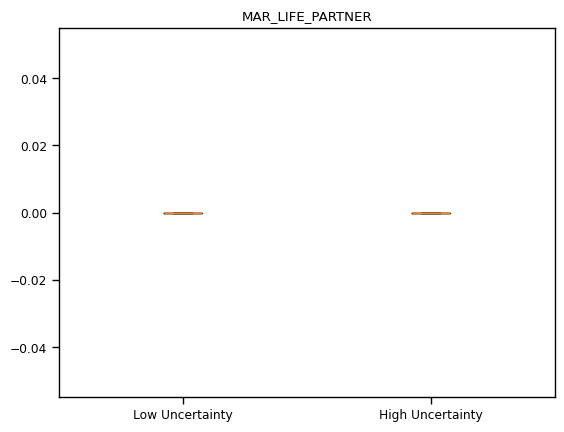

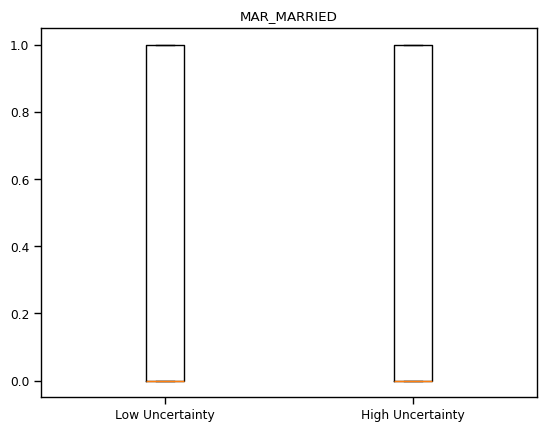

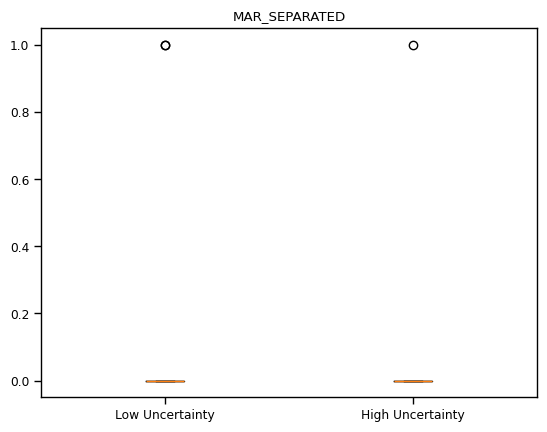

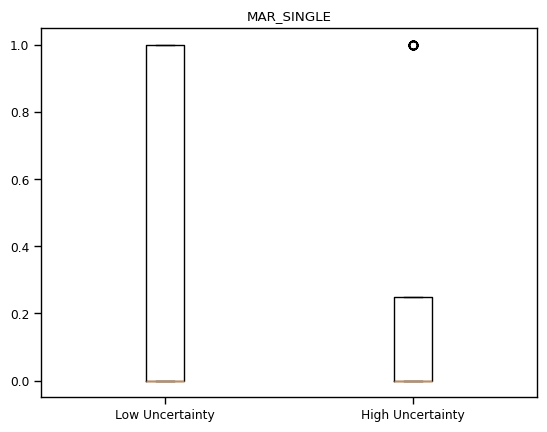

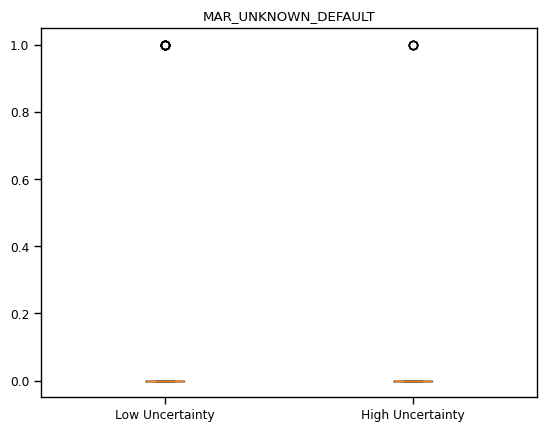

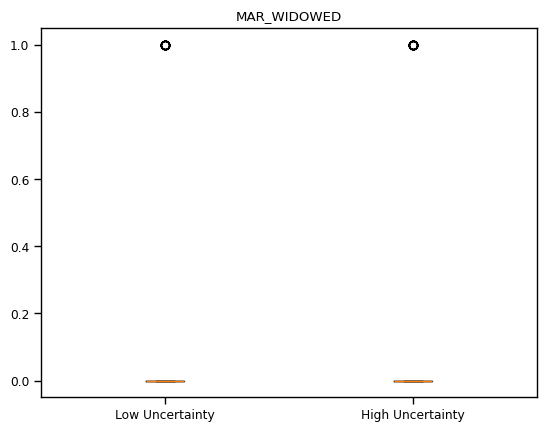

In [245]:
for highest, lowest in zip(df_highest.columns, df_lowest.columns):
    values_low = list(df_lowest[lowest])
    values_high = list(df_highest[highest])
    
    my_dict = {"Low Uncertainty": values_low, "High Uncertainty": values_high}
    
    plt.boxplot(my_dict.values(), labels=my_dict.keys())
    plt.title(str(highest))
    plt.show()

